# Adversarial attacks on 2D double well potential

In this notebook, we reproduce the example of adversarial attacks on the asymetric 2D double well shown in Fig. 2 of [our paper](https://arxiv.org/abs/2101.11588).

The notebook uses the models and the helper functions in the `robust` folder of this repo.

In [1]:
import sys
sys.path.append('..')

import warnings
warnings.simplefilter("ignore")
    
import robust as rb
import torch as ch
import numpy as np

from scipy import stats

from matplotlib import cm
import matplotlib.pyplot as plt

## Creating the 2D double well

Using the potentials available at the `robust` module, we created an asymetric 1D double well with the desired zeros, depth and offset. In particular, the equation for the potential is the following:

$$E(x, y) = 10 x^4 - 10 x^2 + 2x + 4 y^2$$

Then, the `potential` object creates the training set, the `true_potential` is used for the evaluation (e.g. the surrogate model, or analogous to a FF or DFT calculation). We also select the plotting range for the potentials, in order to achieve a better visualization for this work.

In [2]:
AX = 10
BX = 1
CX = 2
AY = 4
BY = 0
CY = 0

ENERGY_THRESHOLD = -2

potential = rb.potentials.Masked2DDoubleWell(
    ax=AX, bx=BX, cx=CX,
    ay=AY, by=BY, cy=CY,    
    emax=ENERGY_THRESHOLD,
    energy_noise=0.0,
)

true_potential = rb.potentials.TwoDimensionalDoubleWell(
    ax=AX, bx=BX, cx=CX,
    ay=AY, by=BY, cy=CY,
)

In [19]:
PLOT_RANGE = 1.2
STEPS = 300

x = np.linspace(-PLOT_RANGE, PLOT_RANGE, STEPS)
y = np.linspace(-PLOT_RANGE, PLOT_RANGE, STEPS)

SHAPE = (len(x), len(y))

X, Y = np.meshgrid(x, y)
XY = np.stack([X.reshape(-1), Y.reshape(-1)], axis=1)
XY = ch.tensor(XY).to(ch.float32)

dplot = rb.PotentialDataset(*true_potential(XY))

In [4]:
xytrain = (2 * ch.rand(800, 2) - 1) * PLOT_RANGE
dset = rb.PotentialDataset(*potential(xytrain))

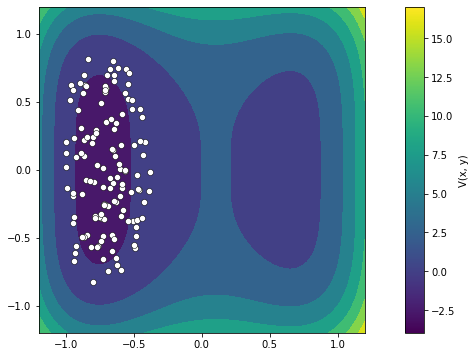

In [21]:
Z = dplot.e.reshape(X.shape).numpy()

cmap = cm.get_cmap("viridis")
norm = cm.colors.Normalize(vmin=np.min(Z), vmax=np.max(Z))
scalarMap = cm.ScalarMappable(norm=norm, cmap=cmap)
c = scalarMap.to_rgba(Z)

fig, (ax, cax) = plt.subplots(1, 2, figsize=(7, 6), gridspec_kw={'width_ratios': (0.9, 0.05)})

ax.contourf(X, Y, Z, c=c, cmap=cmap)

xtrain, ytrain = dset.x[:, 0], dset.x[:, 1]
ax.scatter(xtrain, ytrain, c='w', linewidths=0.5, edgecolors='k')
ax.set_aspect('equal')

cbar = fig.colorbar(scalarMap, shrink=.65, cax=cax, orientation='vertical')
cbar.set_label('V(x, y)')

plt.show()

## Training the models

Now, we select all hyperparameters of the models. The NN ensemble is generated from the `model_params`. The `loss_params` are used both for the training and adversarial loss, although the latter uses only the temperature. `score_params` uses some deduplication strategies, as explained in Sec. II-C of the paper. Afterwards, the initial pipeline (i.e. one loop cycle) is created, and the model is trained.

In [6]:
loss_params = {
    'energy_coef': 1,
    'forces_coef': 10,
    'temperature': 5,
}

model_params = {
    'input_dim': 2,
    'output_dim': 1,
    'num_layers': 4,
    'layer_dim': 1024,
    'num_networks': 5
}

optim_params = {
    'lr': 1e-3,
}

train_params = {
    'max_epochs': 500,
    'batch_size': 35,
}

attack_params = {
    'delta_std': 1e-2,
    'optim_kws': {'lr': 3e-3},
}

score_params = {
    'UncertaintyPercentile': {'percentile': 80},
}

prefix = 'models_2D'

In [7]:
pipeline = rb.ForwardPipeline(
    dset,
    model_params,
    loss_params,
    optim_params,
    train_params,
    attack_params,
    name=f'{prefix}/gen_1',
)
DEVICE = 1

In [8]:
loop = rb.actlearn.ActiveLearning(
    pipeline,
    true_potential,
    device=DEVICE,
    train_epochs=400,
    attack_epochs=600,
    scores=score_params,
    num_generations=7,
    name_prefix=prefix,
)

In [9]:
loop.loop()

ACT_LEARN: GEN 1: training model
 Time | Epoch | Learning rate | Train loss | Validation loss | MAE Energy | MAE Forces | GPU Memory (MB)
16:39 |    25 |     1.000e-03 |   236.0616 |        151.1347 |     3.6393 |    13.9241 |               0
16:40 |    50 |     1.000e-03 |    46.0895 |         33.3430 |     4.8895 |     7.7107 |               0
16:42 |    75 |     1.000e-03 |    27.8952 |         26.5442 |     1.5787 |     6.8618 |               0
16:44 |   100 |     1.000e-03 |    27.1323 |         19.5345 |     1.0942 |     5.6084 |               0
16:45 |   125 |     1.000e-03 |    13.9312 |         13.8434 |     1.3267 |     4.8888 |               0
16:47 |   150 |     1.000e-03 |     7.7100 |         11.4122 |     1.1205 |     4.5906 |               0
16:48 |   175 |     1.000e-03 |     7.2429 |          8.1594 |     0.7317 |     3.4176 |               0
16:49 |   200 |     1.000e-03 |     6.4650 |          7.7971 |     0.8363 |     3.2896 |               0
16:51 |   225 |     1.

22:23 |   125 |     1.000e-03 |     3.0764 |          3.8057 |     1.6380 |     2.3749 |               0
22:28 |   150 |     1.000e-03 |     7.9612 |          6.7366 |     0.8518 |     2.2440 |               0
22:33 |   175 |     1.000e-03 |     0.8873 |          0.2386 |     0.3363 |     0.5149 |               0
22:38 |   200 |     1.000e-03 |     3.3081 |          2.0244 |     1.2181 |     1.4124 |               0
22:42 |   225 |     5.000e-04 |     0.1289 |          0.0633 |     0.1605 |     0.2972 |               0
22:47 |   250 |     5.000e-04 |     0.0892 |          0.0606 |     0.1539 |     0.2782 |               0
22:51 |   275 |     5.000e-04 |     0.0713 |          0.0482 |     0.1777 |     0.2574 |               0
22:56 |   300 |     5.000e-04 |     0.2473 |          0.3623 |     0.1424 |     0.5853 |               0
23:00 |   325 |     5.000e-04 |     0.0608 |          0.0456 |     0.1214 |     0.2399 |               0
23:05 |   350 |     5.000e-04 |     5.4020 |          1

## Plotting the evolution of the active learning loop

This plot reproduces Fig. 2a of the paper, up to differences due to random initialization. It essentially shows all adversarial attacks and the evolution of the uncertainty/loss across generations.

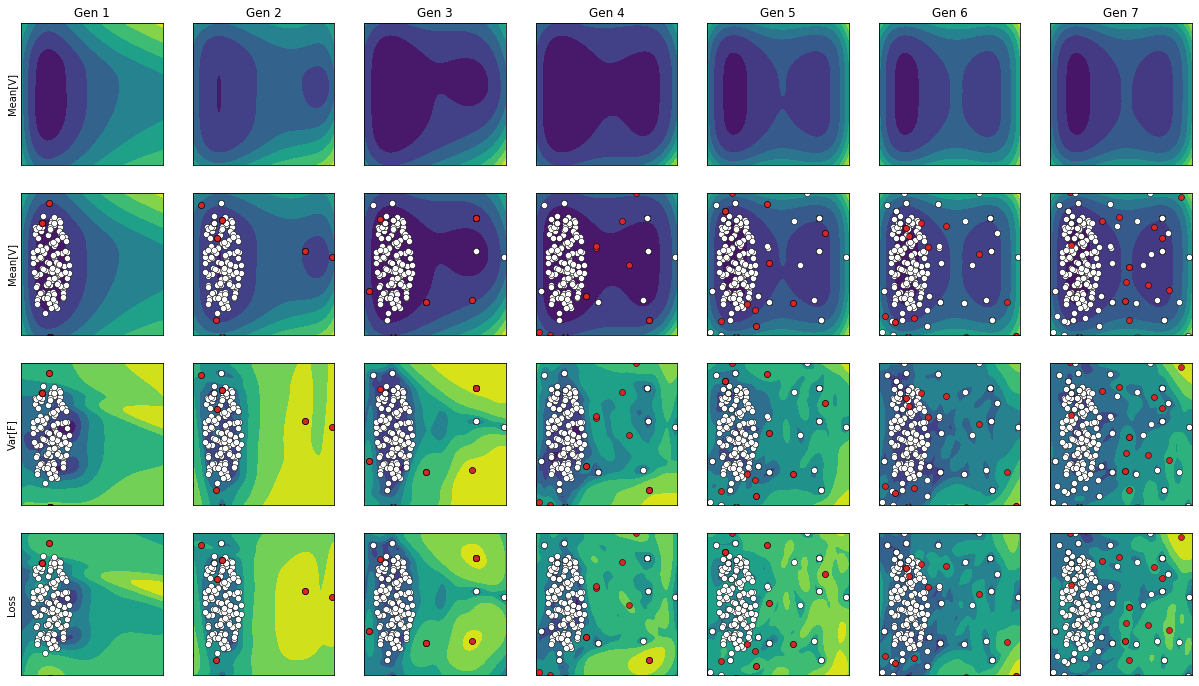

In [22]:
generations = loop.generations
N_GENS = len(generations)
N_PLOTS = 4
LIMS = np.array([-PLOT_RANGE, PLOT_RANGE])

fig, ax_fig = plt.subplots(N_PLOTS, N_GENS, figsize=(N_GENS * 3, N_PLOTS * 3), sharex=True, sharey=True)

for gen, ax_row in zip(generations, ax_fig.T):
    pipeline = gen['pipeline']
    attacks = gen['attacks']
    attacks_truth = rb.PotentialDataset(*true_potential(attacks.x))

    dplot_model, _, _ = pipeline.evaluate(dplot.get_loader(train_params['batch_size']), DEVICE)
    
    ax = ax_row[0]
    ax.contourf(
        dplot_model.x[:, 0].reshape(SHAPE),
        dplot_model.x[:, 1].reshape(SHAPE),
        dplot_model.e.mean(-1).reshape(SHAPE),
        label='prediction',
        zorder=-1
    )    
    ax.set_aspect('equal')
    ax.set_xlim(LIMS)
    ax.set_ylim(LIMS)
    
    ax = ax_row[1]
    ax.contourf(
        dplot_model.x[:, 0].reshape(SHAPE),
        dplot_model.x[:, 1].reshape(SHAPE),
        dplot_model.e.mean(-1).reshape(SHAPE),
        label='prediction',
        zorder=-1
    )
    ax.scatter(
        pipeline.dset.x[:, 0],
        pipeline.dset.x[:, 1],
        c='w',
        linewidths=0.5,
        edgecolors='k',
        label='training data',
    )
    
    if len(pipeline.dset_train) > 1:
        ax.scatter(
            pipeline.dset_train.x[:, 0],
            pipeline.dset_train.x[:, 1],
            c='w',
            linewidths=0.5,
            edgecolors='k',
            label='training data',
        )

    if len(attacks) > 0:
        ax.scatter(
            attacks_truth.x[:, 0],
            attacks_truth.x[:, 1],
            c='#d62627',
            linewidths=0.5,
            edgecolors='k',
            label='attacks',
        )
    
    ax.set_aspect('equal')
    
    ax.set_xlim(LIMS)
    ax.set_ylim(LIMS)

    ax = ax_row[2]
    ax.contourf(
        dplot_model.x[:, 0].reshape(SHAPE),
        dplot_model.x[:, 1].reshape(SHAPE),
        ch.log(dplot_model.f.var(-1).sum(-1)).reshape(SHAPE),
        label='Var[F]',
        zorder=-1
    )
    ax.scatter(
        pipeline.dset.x[:, 0],
        pipeline.dset.x[:, 1],
        c='w',
        linewidths=0.5,
        edgecolors='k',
        label='training data',
    )
    
    if len(pipeline.dset_train) > 1:
        ax.scatter(
            pipeline.dset_train.x[:, 0],
            pipeline.dset_train.x[:, 1],
            c='w',
            linewidths=0.5,
            edgecolors='k',
            label='training data',
        )
        
    if len(attacks) > 0:
        ax.scatter(
            attacks_truth.x[:, 0],
            attacks_truth.x[:, 1],
            c='#d62627',
            linewidths=0.5,
            edgecolors='k',
            label='attacks',
        )
    
    ax.set_aspect('equal')
    
    ax.set_xlim(LIMS)
    ax.set_ylim(LIMS)
    
    ax = ax_row[3]
    adv_loss = pipeline.get_adv_loss()
    loss = -adv_loss.loss_fn(dplot_model.x, dplot_model.e, dplot_model.f).sum(-1)
    
    ax.contourf(
        dplot_model.x[:, 0].reshape(SHAPE),
        dplot_model.x[:, 1].reshape(SHAPE),
        ch.log(loss).reshape(SHAPE),
        label='loss',
        zorder=-1
    )
    ax.scatter(
        pipeline.dset.x[:, 0],
        pipeline.dset.x[:, 1],
        c='w',
        linewidths=0.5,
        edgecolors='k',
        label='training data',
    )
    
    if len(pipeline.dset_train) > 1:
        ax.scatter(
            pipeline.dset_train.x[:, 0],
            pipeline.dset_train.x[:, 1],
            c='w',
            linewidths=0.5,
            edgecolors='k',
            label='training data',
        )
        
    if len(attacks) > 0:
        ax.scatter(
            attacks_truth.x[:, 0],
            attacks_truth.x[:, 1],
            c='#d62627',
            linewidths=0.5,
            edgecolors='k',
            label='attacks',
        )
    
    ax.set_aspect('equal')
    
    ax.set_xlim(LIMS)
    ax.set_ylim(LIMS)

ax_fig[0, 0].set_ylabel('Mean[V]')
ax_fig[1, 0].set_ylabel('Mean[V]')
ax_fig[2, 0].set_ylabel('Var[F]')
ax_fig[3, 0].set_ylabel('Loss')

for ax, gen in zip(ax_fig[0, :].reshape(-1), generations):
    ax.set_title(f"Gen {gen['generation']}")
    
for ax in ax_fig.reshape(-1):
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Exporting the data

In [157]:
ch.save(loop.generations, '/home/dskoda/projects/final-project-atomistic-uncertainty/notebook/loop.pth.tar')

In [77]:
import pandas as pd
import tqdm
import os

In [84]:
COLS = ['x', 'y', 'avgE', 'stdE', 'avgFx', 'avgFy', 'stdFx', 'stdFy', 'loss']

def get_data(dset, loss_fn):
    loss = -loss_fn.loss_fn(dset.x, dset.e, dset.f).sum(-1)
    
    return ch.cat([
        dset.x,
        dset.e.mean(-1).view(-1, 1),
        dset.e.std(-1).view(-1, 1),
        dset.f.mean(-1),
        dset.f.std(-1),
        loss.view(-1, 1),
    ], dim=1).numpy()

def get_dataframe(dset, dset_name, generation, loss_fn):
    df = pd.DataFrame(get_data(dset, loss_fn), columns=COLS)
    df['type'] = dset_name
    df['generation'] = generation
    
    return df

In [85]:
dataframes = []
for gen in tqdm.tqdm(loop.generations):
    pipeline = gen['pipeline']
    attacks = gen['attacks']
    loss_fn = pipeline.get_adv_loss()
    
    trainset = pipeline.dset + pipeline.dset_train
    dtrain_model, _, _ = pipeline.evaluate(trainset.get_loader(batch_size=30000), DEVICE)
    dplot_model, _, _ = pipeline.evaluate(dplot.get_loader(batch_size=30000), DEVICE)
    
    attacks_df = get_dataframe(attacks, 'attack', gen['generation'], loss_fn)
    train_df = get_dataframe(dtrain_model, 'train', gen['generation'], loss_fn)
    contour_df = get_dataframe(dplot_model, 'contour', gen['generation'], loss_fn)
    
    df = pd.concat([attacks_df, train_df, contour_df], axis=0)
    
    dataframes.append(df)

100%|██████████| 7/7 [00:13<00:00,  1.99s/it]


In [86]:
df = pd.concat(dataframes, axis=0)

In [69]:
df.to_csv('/home/dskoda/projects/final-project-atomistic-uncertainty/data/doublewell.csv')

## Plotting from the dataframe

In [78]:
FIGS_PATH = '/home/dskoda/projects/final-project-atomistic-uncertainty/figs/'

In [143]:
cmap = cm.inferno
mappable = cm.ScalarMappable(cmap=cmap)

In [131]:
levels = np.arange(-5, 6).tolist()

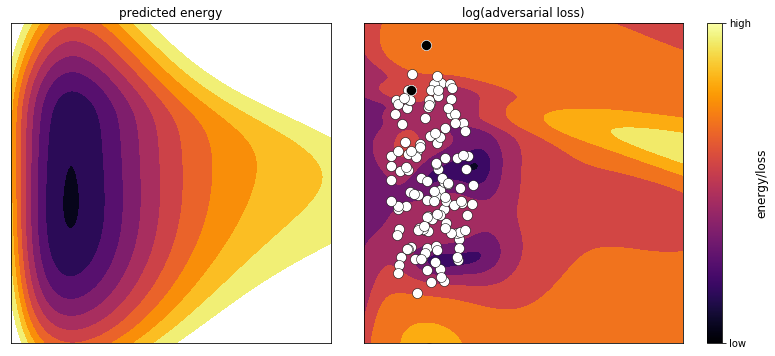

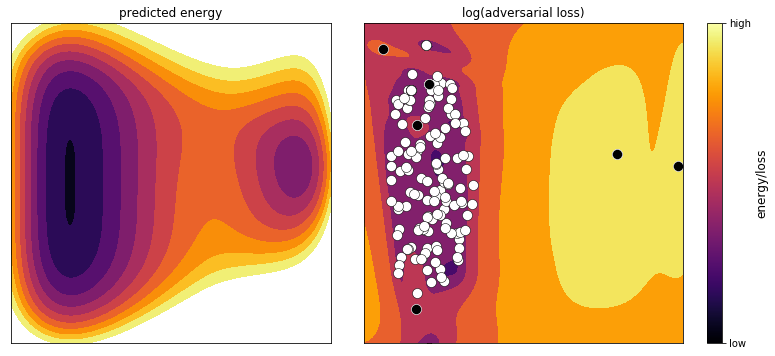

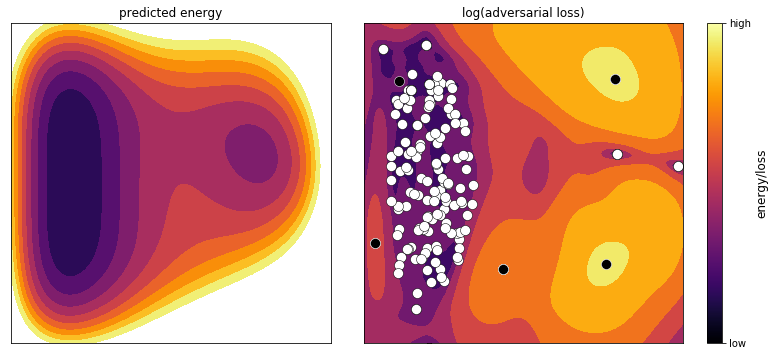

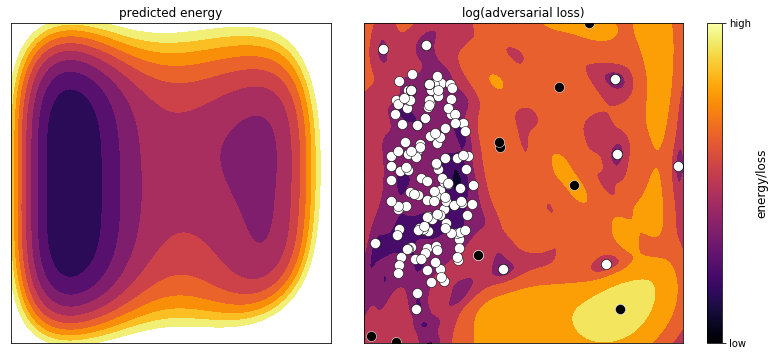

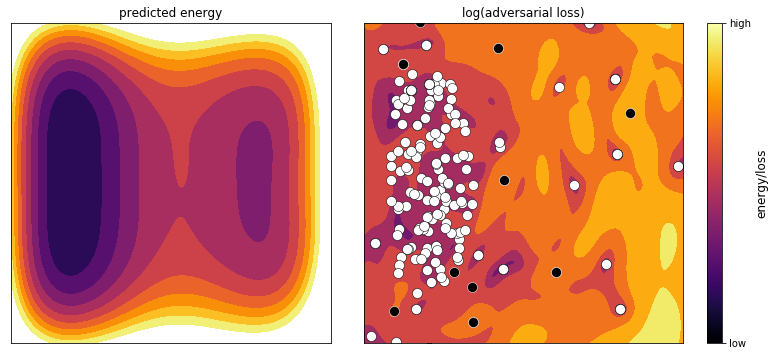

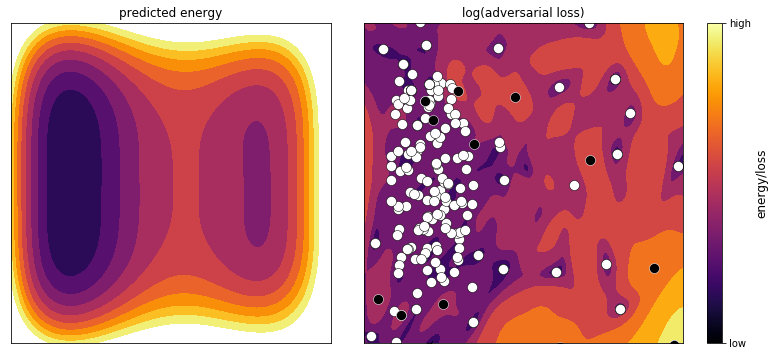

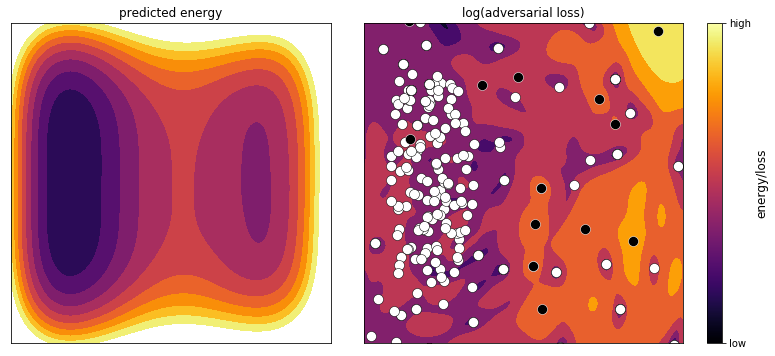

In [144]:
LIMS = np.array([-PLOT_RANGE, PLOT_RANGE])

for gen in df.generation.unique():
    fig, ax_fig = plt.subplots(1, 3, figsize=(11, 5), gridspec_kw={'width_ratios': (0.45, 0.45, 0.02)})
    
    gendf = df.loc[df.generation == gen]
    
    contdf = gendf.loc[gendf.type == 'contour']
    traindf = gendf.loc[gendf.type == 'train']
    attackdf = gendf.loc[gendf.type == 'attack']
    
    ax = ax_fig[0]
    ctf = ax.contourf(
        contdf.x.values.reshape(SHAPE),
        contdf.y.values.reshape(SHAPE),
        contdf.avgE.values.reshape(SHAPE),
        levels=levels,
        label='Avg[E]',
        zorder=-1,
        cmap='inferno'
    )
    ax.set_title('predicted energy')
    
    ax = ax_fig[1]
    ax.contourf(
        contdf.x.values.reshape(SHAPE),
        contdf.y.values.reshape(SHAPE),
        np.log(contdf.loss.values.reshape(SHAPE)),
        label='Loss',
        zorder=-1,
        cmap='inferno'
    )
    ax.scatter(
        traindf.x.values,
        traindf.y.values,
        c='w',
        s=100,
        linewidths=0.5,
        edgecolors='k',
        label='training data',
    )
    ax.scatter(
        attackdf.x.values,
        attackdf.y.values,
        c='k',
        s=100,
        linewidths=0.5,
        edgecolors='w',
        label='training data',
    )
    ax.set_title('log(adversarial loss)')
    
    ax = ax_fig[2]
    cbar = fig.colorbar(mappable, cax=ax)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['low', 'high'])
    cbar.set_label('energy/loss', fontsize=12)
    
    for ax in ax_fig[:2]:
        ax.set_xlim(LIMS)
        ax.set_ylim(LIMS)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    
    fig.tight_layout()
    plt.show()
    
    fig.savefig(os.path.join(FIGS_PATH, 'doublewell', f'gen{gen}.svg'), bbox_inches='tight')

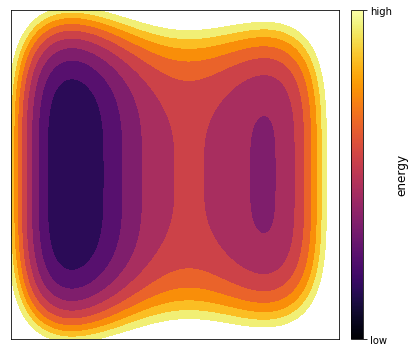

In [159]:
fig, (ax, cax) = plt.subplots(1, 2, figsize=(6, 5), gridspec_kw={'width_ratios': (0.9, 0.03)})

ax.contourf(X, Y, Z, c=c, levels=levels, cmap=cmap)

ax.set_xlim(LIMS)
ax.set_ylim(LIMS)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

cbar = fig.colorbar(mappable, shrink=.65, cax=cax, orientation='vertical')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['low', 'high'])
cbar.set_label('energy', fontsize=12)

fig.tight_layout()
fig.savefig(os.path.join(FIGS_PATH, 'doublewell', 'truth.svg'), bbox_inches='tight')
plt.show()

## Showing a test case using gen 2:

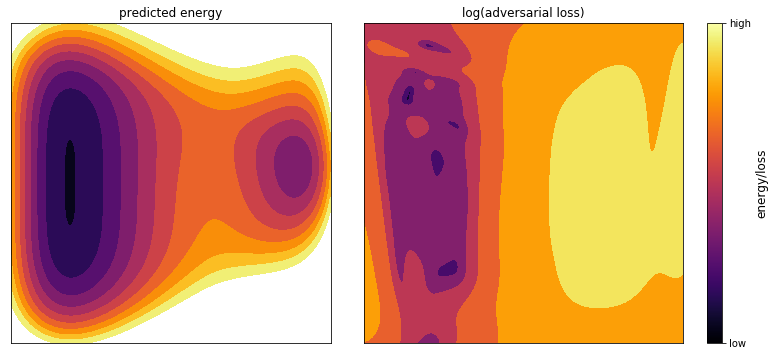

In [248]:
LIMS = np.array([-PLOT_RANGE, PLOT_RANGE])

gen = 2
fig, ax_fig = plt.subplots(1, 3, figsize=(11, 5), gridspec_kw={'width_ratios': (0.45, 0.45, 0.02)})

gendf = df.loc[df.generation == gen]

contdf = gendf.loc[gendf.type == 'contour']
traindf = gendf.loc[gendf.type == 'train']
attackdf = gendf.loc[gendf.type == 'attack']

ax = ax_fig[0]
ctf = ax.contourf(
    contdf.x.values.reshape(SHAPE),
    contdf.y.values.reshape(SHAPE),
    contdf.avgE.values.reshape(SHAPE),
    levels=levels,
    label='Avg[E]',
    zorder=-1,
    cmap='inferno'
)
ax.set_title('predicted energy')

ax = ax_fig[1]
ax.contourf(
    contdf.x.values.reshape(SHAPE),
    contdf.y.values.reshape(SHAPE),
    np.log(contdf.loss.values.reshape(SHAPE)),
    label='Loss',
    zorder=-1,
    cmap='inferno'
)
ax.set_title('log(adversarial loss)')

ax = ax_fig[2]
cbar = fig.colorbar(mappable, cax=ax)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['low', 'high'])
cbar.set_label('energy/loss', fontsize=12)

for ax in ax_fig[:2]:
    ax.set_xlim(LIMS)
    ax.set_ylim(LIMS)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

fig.tight_layout()
plt.show()

fig.savefig(os.path.join(FIGS_PATH, 'doublewell', f'gen{gen}_example.svg'), bbox_inches='tight')

## Making a test case for the project

In [160]:
gendf = df.loc[df.generation == 2]
    
contdf = gendf.loc[gendf.type == 'contour']
traindf = gendf.loc[gendf.type == 'train']
attackdf = gendf.loc[gendf.type == 'attack']

In [189]:
xset = contdf.x.unique()[::3]
yset = contdf.y.unique()[::3]

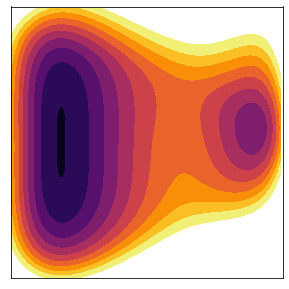

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

df_ = contdf.loc[contdf.x.isin(xset) & contdf.y.isin(yset)]
NEWSHAPE = (100, 100)

ctf = ax.contourf(
    df_.x.values.reshape(NEWSHAPE),
    df_.y.values.reshape(NEWSHAPE),
    df_.avgE.values.reshape(NEWSHAPE),
    levels=levels,
    label='Avg[E]',
#     zorder=-1,
    cmap='inferno'
)

ax.set_xlim(LIMS)
ax.set_ylim(LIMS)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.show()

In [229]:
tdf = pd.concat([df_, attackdf, traindf], axis=0)

tdset = rb.PotentialDataset(
    tdf[['x', 'y']].values,
    tdf['avgE'].values.reshape(-1, 1),
    tdf[['avgFx', 'avgFy']].values,
)

In [230]:
tvals, _, _ = generations[1]['pipeline'].evaluate(tdset.get_loader(train_params['batch_size']), DEVICE)

In [233]:
cols = [f'E_{i}' for i in range(1, 6)] + [f'Fx_{i}' for i in range(1, 6)] + [f'Fy_{i}' for i in range(1, 6)]
details_df = pd.DataFrame(
    ch.cat([
        tvals.e.reshape(-1, 5),
        tvals.f.reshape(-1, 10),
    ], dim=1).numpy(),
    columns=cols,
)

In [242]:
final_details = pd.concat([tdf.reset_index(drop=True), details_df], axis=1)

In [244]:
final_details.to_csv('/home/dskoda/projects/final-project-atomistic-uncertainty/data/doublewell_details.csv')

## Analyzing

In [259]:
final_details.loc[final_details.type == 'train'].sort_values('y').iloc[-1]

x              -0.728349
y                1.03586
avgE             0.81076
stdE           0.0548092
avgFx           -1.16642
avgFy           -17.7688
stdFx          0.0580807
stdFy            0.03087
loss          0.00105888
type               train
generation             2
E_1             0.770925
E_2              0.77577
E_3             0.798435
E_4              0.80307
E_5             0.905598
Fx_1            -1.25714
Fx_2            -1.13704
Fx_3            -1.15046
Fx_4            -1.10427
Fx_5             -1.1832
Fy_1            -17.7415
Fy_2            -17.7917
Fy_3            -17.7748
Fy_4            -17.8035
Fy_5            -17.7327
Name: 10166, dtype: object

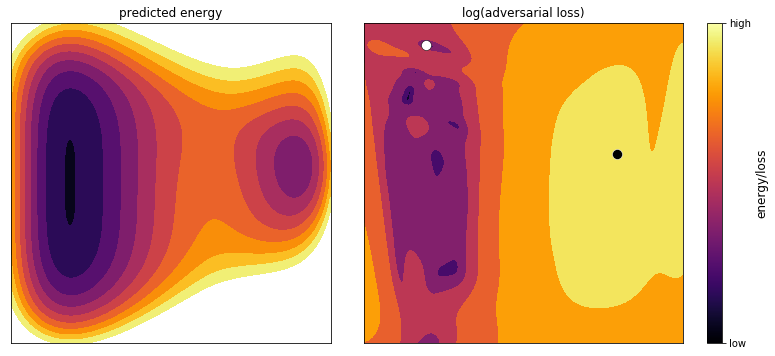

In [258]:
LIMS = np.array([-PLOT_RANGE, PLOT_RANGE])

gen = 2
fig, ax_fig = plt.subplots(1, 3, figsize=(11, 5), gridspec_kw={'width_ratios': (0.45, 0.45, 0.02)})

gendf = df.loc[df.generation == gen]

contdf = gendf.loc[gendf.type == 'contour']
traindf = gendf.loc[gendf.type == 'train'].sort_values('y').iloc[-1]
attackdf = gendf.loc[gendf.type == 'attack'].iloc[1]

ax = ax_fig[0]
ctf = ax.contourf(
    contdf.x.values.reshape(SHAPE),
    contdf.y.values.reshape(SHAPE),
    contdf.avgE.values.reshape(SHAPE),
    levels=levels,
    label='Avg[E]',
    zorder=-1,
    cmap='inferno'
)
ax.set_title('predicted energy')

ax = ax_fig[1]
ax.contourf(
    contdf.x.values.reshape(SHAPE),
    contdf.y.values.reshape(SHAPE),
    np.log(contdf.loss.values.reshape(SHAPE)),
    label='Loss',
    zorder=-1,
    cmap='inferno'
)
ax.scatter(
    traindf.x,
    traindf.y,
    c='w',
    s=100,
    linewidths=0.5,
    edgecolors='k',
    label='training data',
)
ax.scatter(
    attackdf.x,
    attackdf.y,
    c='k',
    s=100,
    linewidths=0.5,
    edgecolors='w',
    label='training data',
)
ax.set_title('log(adversarial loss)')

ax = ax_fig[2]
cbar = fig.colorbar(mappable, cax=ax)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['low', 'high'])
cbar.set_label('energy/loss', fontsize=12)

for ax in ax_fig[:2]:
    ax.set_xlim(LIMS)
    ax.set_ylim(LIMS)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

fig.tight_layout()
plt.show()

fig.savefig(os.path.join(FIGS_PATH, 'doublewell', f'gen{gen}_example.svg'), bbox_inches='tight')